# Multiple Linear Regression Model #

### Time Series Regression Explaining Stock's Returns ###

In [5]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_daily_financial_data

# Pretty Notation
from IPython.display import display, Math

The Multiple Linear Regression Model implies matrix notation:

1) $ \mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon} $

In [7]:
# Call the stock's data (our dependent variable Y)
stock = 'AAPL'

data_stock = import_daily_financial_data(
    ticker=stock, 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_stock

[*********************100%***********************]  1 of 1 completed


Price            close        high         low        open     volume  \
Date                                                                    
2015-01-05   23.604336   24.137516   23.417723   24.057539  257142000   
2015-01-06   23.606554   23.866479   23.244435   23.668758  263188400   
2015-01-07   23.937569   24.037539   23.704302   23.815381  160423600   
2015-01-08   24.857298   24.915060   24.148612   24.266358  237458000   
2015-01-09   24.883966   25.159442   24.484081   25.030590  214798000   
...                ...         ...         ...         ...        ...   
2024-12-24  257.578674  257.588630  254.675658  254.875189   23234700   
2024-12-26  258.396667  259.474086  257.010028  257.568678   27237100   
2024-12-27  254.974930  258.077462  252.451019  257.209530   42355300   
2024-12-30  251.593094  252.889969  250.146586  251.623020   35557500   
2024-12-31  249.817383  252.670501  248.829760  251.832526   39480700   

Price        returns  
Date                  
2015-01-05 -0.028576  
2015-01-06  0.000094  
2015-01-07  0.013925  
2015-01-08  0.037702  
2015-01-09  0.001072  
...              ...  
2024-12-24  0.011413  
2024-12-26  0.003171  
2024-12-27 -0.013331  
2024-12-30 -0.013352  
2024-12-31 -0.007083  

[2515 rows x 6 columns]

In [11]:
# Data S&P500
data_sp500 = import_daily_financial_data(
    ticker='^GSPC', 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

sector = 'IWY'

#Tech ETF
data_sector =  import_daily_financial_data(
    ticker=sector, 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

# Dollar Index
data_dxy =  import_daily_financial_data(
    ticker='DX-Y.NYB', 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

# 10-Year Bond Yield
data_tnx = import_daily_financial_data(
    ticker='^TNX', 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=False
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
# Function to calculate daily rate
def annual_to_daily_rate(
        series, 
        days_per_year=252
):
    # From % to decimal
    decimal_series = series / 100
    
    #Calculate the Rate
    return (1 + decimal_series) ** (1 / days_per_year) - 1

In [16]:
# Calculate daily rate
data_tnx['daily_rate'] = annual_to_daily_rate(data_tnx['close'])

data_tnx

Price       close   high    low   open  volume   returns  daily_rate
Date                                                                
2015-01-05  2.039  2.109  2.037  2.102       0 -0.040371    0.000080
2015-01-06  1.963  1.997  1.889  1.968       0 -0.037986    0.000077
2015-01-07  1.954  2.008  1.938  1.975       0 -0.004595    0.000077
2015-01-08  2.016  2.030  1.988  2.004       0  0.031237    0.000079
2015-01-09  1.971  2.021  1.943  1.997       0 -0.022574    0.000077
...           ...    ...    ...    ...     ...       ...         ...
2024-12-24  4.591  4.629  4.583  4.609       0 -0.001741    0.000178
2024-12-26  4.579  4.641  4.573  4.631       0 -0.002617    0.000178
2024-12-27  4.619  4.623  4.575  4.603       0  0.008698    0.000179
2024-12-30  4.545  4.577  4.537  4.577       0 -0.016150    0.000176
2024-12-31  4.573  4.587  4.521  4.529       0  0.006142    0.000177

[2514 rows x 7 columns]

In [18]:
# Create the Data we will need

data_regression = pd.DataFrame(index=data_stock.index)

# Now safely add new columns
data_regression['returns'] = data_stock['returns']
data_regression['mkt_returns'] = data_sp500['returns']
data_regression['sector_returns'] = data_sector['returns']
data_regression['dollar_returns'] = data_dxy['returns']
data_regression['10_year_bond'] = data_tnx['daily_rate']

# Drop nans
data_regression.dropna(inplace = True)

data_regression

returns  mkt_returns  sector_returns  dollar_returns  \
Date                                                                
2015-01-05 -0.028576    -0.018447       -0.016820        0.003288   
2015-01-06  0.000094    -0.008933       -0.009333        0.001312   
2015-01-07  0.013925     0.011563        0.012760        0.004253   
2015-01-08  0.037702     0.017730        0.018346        0.005210   
2015-01-09  0.001072    -0.008439       -0.007537       -0.004666   
...              ...          ...             ...             ...   
2024-12-24  0.011413     0.010982        0.013657        0.002034   
2024-12-26  0.003171    -0.000406       -0.001805       -0.001202   
2024-12-27 -0.013331    -0.011117       -0.014681       -0.001203   
2024-12-30 -0.013352    -0.010760       -0.012155        0.001203   
2024-12-31 -0.007083    -0.004294       -0.007917        0.003324   

            10_year_bond  
Date                      
2015-01-05      0.000080  
2015-01-06      0.000077  
2015-01-07      0.000077  
2015-01-08      0.000079  
2015-01-09      0.000077  
...                  ...  
2024-12-24      0.000178  
2024-12-26      0.000178  
2024-12-27      0.000179  
2024-12-30      0.000176  
2024-12-31      0.000177  

[2513 rows x 5 columns]

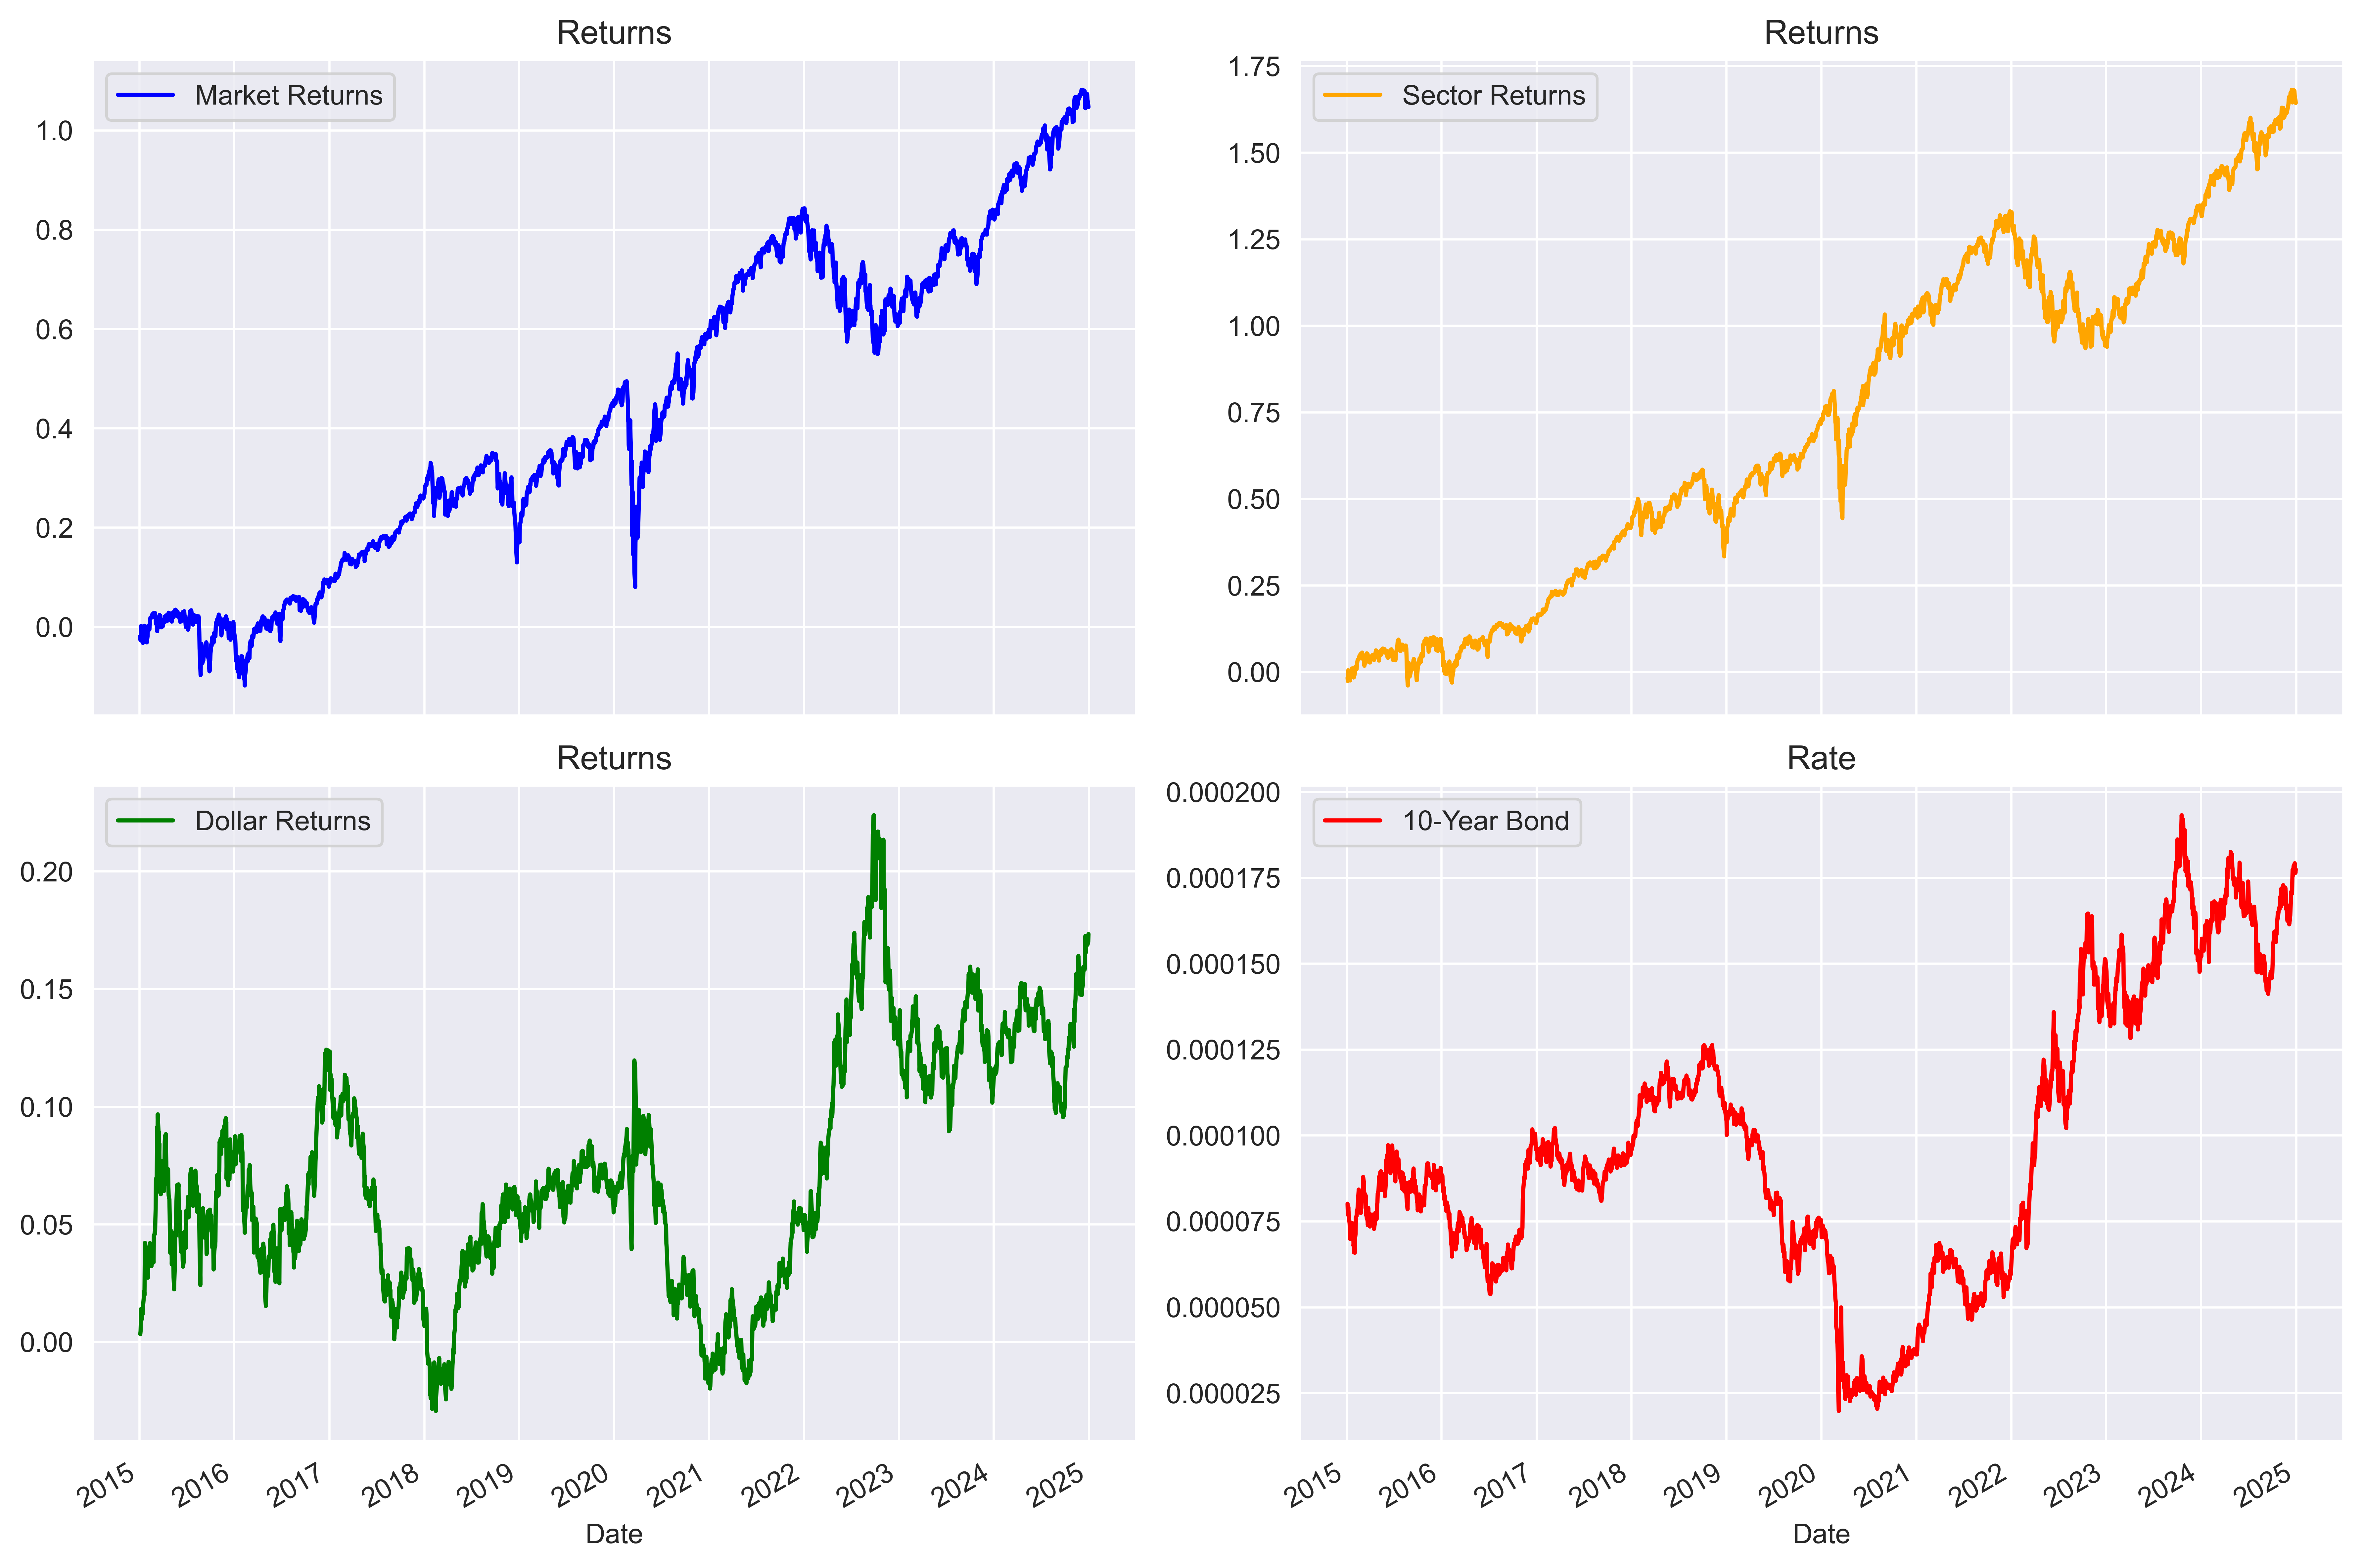

In [22]:
# Make a Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=600, sharex=True)  # 2 rows, 2 columns

# First Graph
data_regression['mkt_returns'].cumsum().plot(ax=axs[0, 0], color='blue', label='Market Returns')
axs[0, 0].set_title('Returns')
axs[0, 0].legend()

# Second Graph
data_regression['sector_returns'].cumsum().plot(ax=axs[0, 1], color='orange', label='Sector Returns')
axs[0, 1].set_title('Returns')
axs[0, 1].legend()

# Third Graph
data_regression['dollar_returns'].cumsum().plot(ax=axs[1, 0], color='green', label='Dollar Returns')
axs[1, 0].set_title('Returns')
axs[1, 0].legend()

# Fourth
data_regression['10_year_bond'].plot(ax=axs[1, 1], color='red', label='10-Year Bond')
axs[1, 1].set_title('Rate')
axs[1, 1].legend()

# Show
plt.tight_layout()
plt.show()

In [23]:
# Correlation Matrix

data_regression.corr()

returns  mkt_returns  sector_returns  dollar_returns  \
returns         1.000000     0.748185        0.809135       -0.061541   
mkt_returns     0.748185     1.000000        0.950459       -0.110198   
sector_returns  0.809135     0.950459        1.000000       -0.103490   
dollar_returns -0.061541    -0.110198       -0.103490        1.000000   
10_year_bond   -0.020983    -0.003779       -0.004794        0.020630   

                10_year_bond  
returns            -0.020983  
mkt_returns        -0.003779  
sector_returns     -0.004794  
dollar_returns      0.020630  
10_year_bond        1.000000

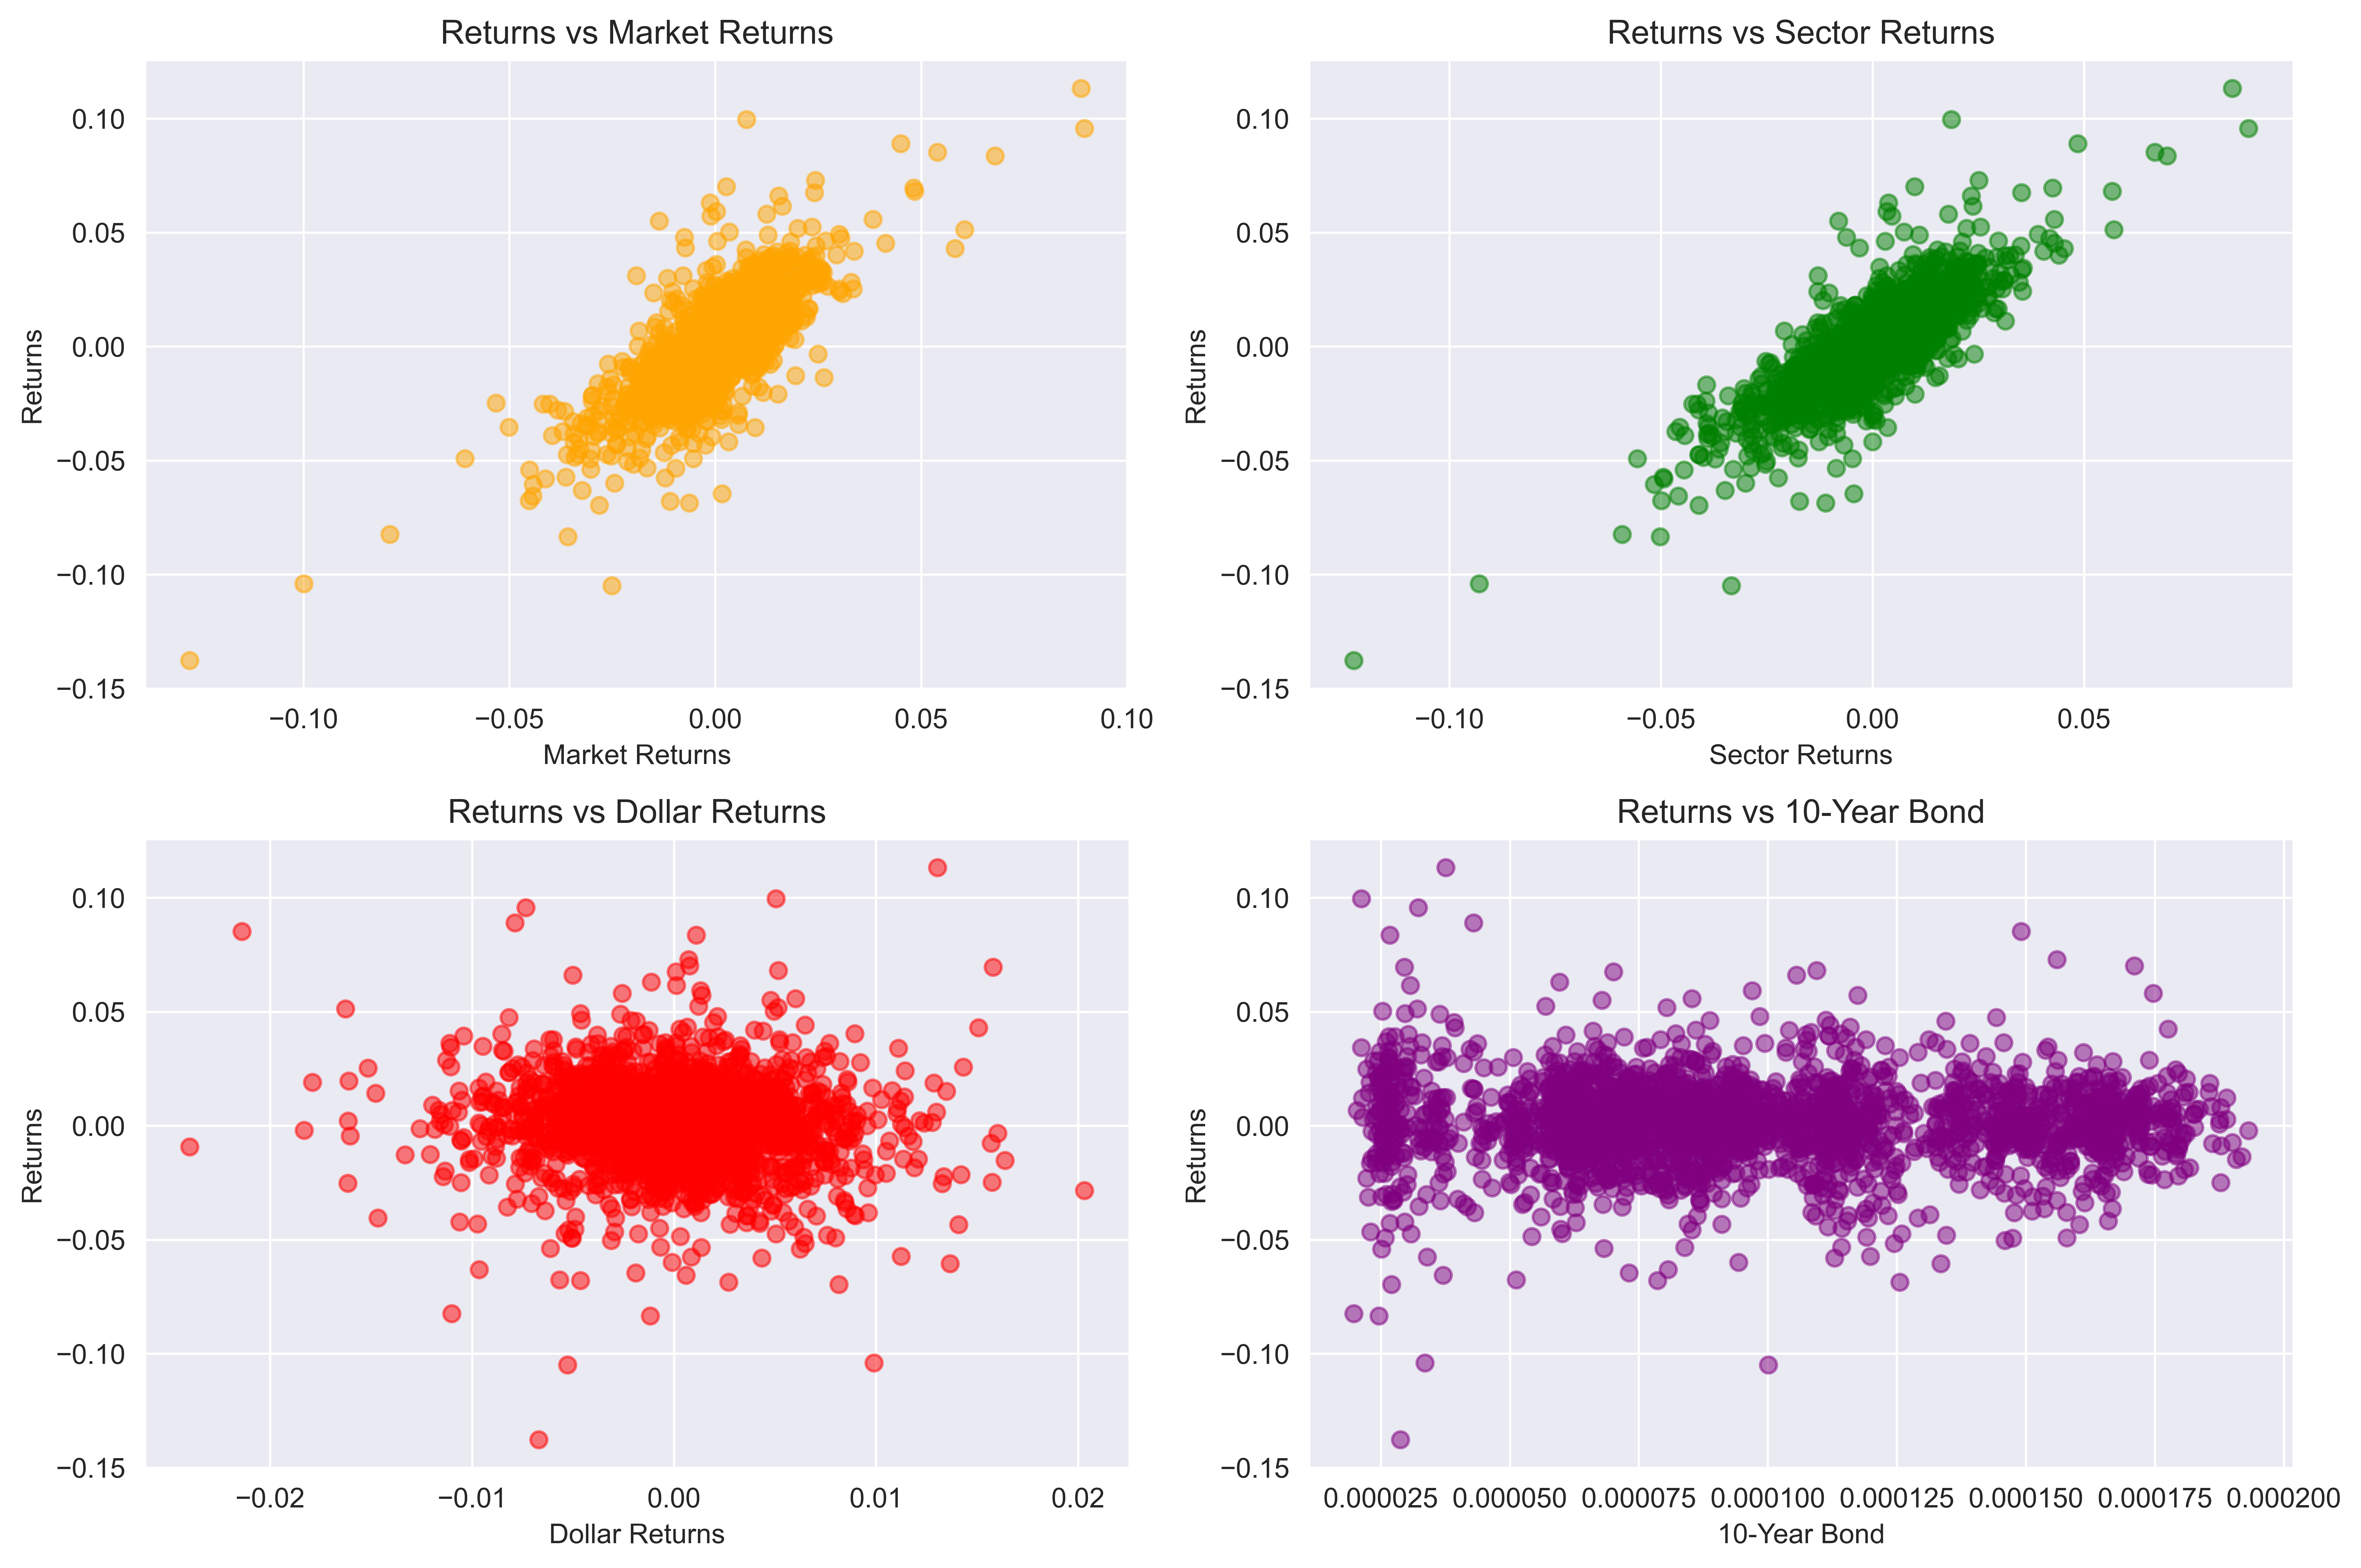

In [24]:
# Setup subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=600)

# Variables to plot against 'returns'
variables = ['mkt_returns', 'sector_returns', 'dollar_returns', '10_year_bond']
titles = ['Market Returns', 'Sector Returns', 'Dollar Returns', '10-Year Bond']
colors = ['orange', 'green', 'red', 'purple']

# Create scatter plots
for i, (var, title, color) in enumerate(zip(variables, titles, colors)):
    row, col = divmod(i, 2)
    axs[row, col].scatter(data_regression[var], data_regression['returns'], alpha=0.5, color=color)
    axs[row, col].set_title(f'Returns vs {title}')
    axs[row, col].set_xlabel(title)
    axs[row, col].set_ylabel('Returns')

# Layout and show
plt.tight_layout()
plt.show()

In [25]:
filtered_data = data_regression[(np.abs(data_regression - data_regression.mean()) <= 3 * data_regression.std())]

filtered_data.dropna(inplace = True)

filtered_data

returns  mkt_returns  sector_returns  dollar_returns  \
Date                                                                
2015-01-05 -0.028576    -0.018447       -0.016820        0.003288   
2015-01-06  0.000094    -0.008933       -0.009333        0.001312   
2015-01-07  0.013925     0.011563        0.012760        0.004253   
2015-01-08  0.037702     0.017730        0.018346        0.005210   
2015-01-09  0.001072    -0.008439       -0.007537       -0.004666   
...              ...          ...             ...             ...   
2024-12-24  0.011413     0.010982        0.013657        0.002034   
2024-12-26  0.003171    -0.000406       -0.001805       -0.001202   
2024-12-27 -0.013331    -0.011117       -0.014681       -0.001203   
2024-12-30 -0.013352    -0.010760       -0.012155        0.001203   
2024-12-31 -0.007083    -0.004294       -0.007917        0.003324   

            10_year_bond  
Date                      
2015-01-05      0.000080  
2015-01-06      0.000077  
2015-01-07      0.000077  
2015-01-08      0.000079  
2015-01-09      0.000077  
...                  ...  
2024-12-24      0.000178  
2024-12-26      0.000178  
2024-12-27      0.000179  
2024-12-30      0.000176  
2024-12-31      0.000177  

[2425 rows x 5 columns]

In [26]:
# The Correlation Matrix

filtered_data.corr()

returns  mkt_returns  sector_returns  dollar_returns  \
returns         1.000000     0.695349        0.768978       -0.062459   
mkt_returns     0.695349     1.000000        0.933489       -0.127017   
sector_returns  0.768978     0.933489        1.000000       -0.107256   
dollar_returns -0.062459    -0.127017       -0.107256        1.000000   
10_year_bond   -0.038230    -0.028908       -0.022380        0.035223   

                10_year_bond  
returns            -0.038230  
mkt_returns        -0.028908  
sector_returns     -0.022380  
dollar_returns      0.035223  
10_year_bond        1.000000

In [27]:
# Create the Y Vector
Y_Vector = filtered_data["returns"]

Y_Vector

Date
2015-01-05   -0.028576
2015-01-06    0.000094
2015-01-07    0.013925
2015-01-08    0.037702
2015-01-09    0.001072
                ...   
2024-12-24    0.011413
2024-12-26    0.003171
2024-12-27   -0.013331
2024-12-30   -0.013352
2024-12-31   -0.007083
Name: returns, Length: 2425, dtype: float64

In [28]:
# Create the Information Matrix
Information_Matrix = filtered_data.copy().drop('returns', axis=1)

# Add a constant
Information_Matrix = sm.add_constant(Information_Matrix)

Information_Matrix

const  mkt_returns  sector_returns  dollar_returns  10_year_bond
Date                                                                        
2015-01-05    1.0    -0.018447       -0.016820        0.003288      0.000080
2015-01-06    1.0    -0.008933       -0.009333        0.001312      0.000077
2015-01-07    1.0     0.011563        0.012760        0.004253      0.000077
2015-01-08    1.0     0.017730        0.018346        0.005210      0.000079
2015-01-09    1.0    -0.008439       -0.007537       -0.004666      0.000077
...           ...          ...             ...             ...           ...
2024-12-24    1.0     0.010982        0.013657        0.002034      0.000178
2024-12-26    1.0    -0.000406       -0.001805       -0.001202      0.000178
2024-12-27    1.0    -0.011117       -0.014681       -0.001203      0.000179
2024-12-30    1.0    -0.010760       -0.012155        0.001203      0.000176
2024-12-31    1.0    -0.004294       -0.007917        0.003324      0.000177

[2425 rows x 5 columns]

In [30]:
# For estimating the coefficients with the OLS we need to assess the non-perfect collinearity condition with the matrix rank
Rank = np.linalg.matrix_rank(Information_Matrix)

# Since we are estimating four betas, the rank must be the number of columns in the Information Matrix
if Rank == len(Information_Matrix.columns):
    print(f"Matrix Rank is {Rank}; there is no evidence of Perfect Multicollinearity.")
else:
    print(f"Matrix Rank is {Rank}; there is evidence of Perfect Multicollinearity between two or more variables.")

Matrix Rank is 5; there is no evidence of Perfect Multicollinearity.


The beta calculation in the Matrix Form:
1) $ \boldsymbol{\beta}=(\mathbf{X}^⊤\mathbf{X})^{-1}(\mathbf{X}^⊤\mathbf{y}) $

The vector of betas is a kx1 vector containing the coefficients of the regression model, where k is the number of parameters to estimate

In [32]:
# Transpose of the Information Matrix
Information_Matrix_T = Information_Matrix.transpose()

Information_Matrix_T

Date            2015-01-05  2015-01-06  2015-01-07  2015-01-08  2015-01-09  \
const             1.000000    1.000000    1.000000    1.000000    1.000000   
mkt_returns      -0.018447   -0.008933    0.011563    0.017730   -0.008439   
sector_returns   -0.016820   -0.009333    0.012760    0.018346   -0.007537   
dollar_returns    0.003288    0.001312    0.004253    0.005210   -0.004666   
10_year_bond      0.000080    0.000077    0.000077    0.000079    0.000077   

Date            2015-01-12  2015-01-13  2015-01-14  2015-01-15  2015-01-16  \
const             1.000000    1.000000    1.000000    1.000000    1.000000   
mkt_returns      -0.008127   -0.002582   -0.005830   -0.009291    0.013335   
sector_returns   -0.006993   -0.001605   -0.005235   -0.008107    0.012136   
dollar_returns    0.000435    0.003581   -0.001626    0.002059    0.001839   
10_year_bond      0.000075    0.000074    0.000072    0.000070    0.000071   

Date            ...  2024-12-17  2024-12-18  2024-12-19  2024-12-20  \
const           ...    1.000000    1.000000    1.000000    1.000000   
mkt_returns     ...   -0.003871   -0.029937   -0.000865    0.010810   
sector_returns  ...   -0.002827   -0.034090    0.000424    0.010551   
dollar_returns  ...    0.000935    0.009954    0.003511   -0.007314   
10_year_bond    ...    0.000170    0.000174    0.000177    0.000176   

Date            2024-12-23  2024-12-24  2024-12-26  2024-12-27  2024-12-30  \
const             1.000000    1.000000    1.000000    1.000000    1.000000   
mkt_returns       0.007261    0.010982   -0.000406   -0.011117   -0.010760   
sector_returns    0.010524    0.013657   -0.001805   -0.014681   -0.012155   
dollar_returns    0.003895    0.002034   -0.001202   -0.001203    0.001203   
10_year_bond      0.000178    0.000178    0.000178    0.000179    0.000176   

Date            2024-12-31  
const             1.000000  
mkt_returns      -0.004294  
sector_returns   -0.007917  
dollar_returns    0.003324  
10_year_bond      0.000177  

[5 rows x 2425 columns]

In [33]:
# Now we have to calculate the (X^⊤X)^{-1}, first the square of the Information Matrix
Information_Matrix_Square = Information_Matrix_T.dot(Information_Matrix)

# We could also use the command Information_Matrix_T @ Information_Matrix
Information_Matrix_Square

const  mkt_returns  sector_returns  dollar_returns  \
const           2425.000000     1.747402        2.407188        0.162844   
mkt_returns        1.747402     0.188137        0.208926       -0.010723   
sector_returns     2.407188     0.208926        0.266003       -0.010711   
dollar_returns     0.162844    -0.010723       -0.010711        0.038989   
10_year_bond       0.236098     0.000145        0.000211        0.000030   

                10_year_bond  
const               0.236098  
mkt_returns         0.000145  
sector_returns      0.000211  
dollar_returns      0.000030  
10_year_bond        0.000027

In [34]:
# The reason we needed to know the rank of the information matrix is because, only full rank matrix can be invertible
# Then we can calculate the Matrix Determinant, if it is different from zero, we can calculate the OLS coefficients

Information_Matrix_Square_Determinant = np.linalg.det(Information_Matrix_Square)

if Information_Matrix_Square_Determinant != 0:
    print(f"The Determinant of the Squared Information Matrix is {Information_Matrix_Square_Determinant} and different from zero")
else:
    print("Matrix NOT invertible")

The Determinant of the Squared Information Matrix is 2.345870386797461e-06 and different from zero


In [35]:
# Now we have to get the Inverse Matrix
X_Variance_Matrix_Inverse = np.linalg.inv(Information_Matrix_Square)

X_Variance_Matrix_Inverse

array([[ 2.79654354e-03, -4.06733157e-03, -2.48441186e-03,
         5.16525396e-03, -2.44363483e+01],
       [-4.06733157e-03,  4.18654645e+01, -3.27972549e+01,
         2.47238486e+00,  6.46090105e+01],
       [-2.48441186e-03, -3.27972549e+01,  2.95321728e+01,
        -8.72619231e-01, -3.22439298e+01],
       [ 5.16525396e-03,  2.47238486e+00, -8.72619231e-01,
         2.61280397e+01, -8.04760347e+01],
       [-2.44363483e+01,  6.46090105e+01, -3.22439298e+01,
        -8.04760347e+01,  2.50895747e+05]])

In [36]:
# Now we have to obtain (X^⊤Y)
Y_Covariance_X = Information_Matrix_T.dot(Y_Vector)

Y_Covariance_X

const             2.939156
mkt_returns       0.221849
sector_returns    0.291525
dollar_returns   -0.008817
10_year_bond      0.000230
dtype: float64

In [37]:
# Now we can calculate the Betas
Beta = X_Variance_Matrix_Inverse.dot(Y_Covariance_X)

Beta_DF = pd.DataFrame(Beta, index = Information_Matrix.columns)
Beta_DF

0
const           0.000919
mkt_returns    -0.292282
sector_returns  1.326293
dollar_returns  0.060390
10_year_bond   -8.395698

In [38]:
# Now we can obtain the fitted values
Y_Hat = Information_Matrix.dot(Beta)

Y_Hat

Date
2015-01-05   -0.016471
2015-01-06   -0.009416
2015-01-07    0.014075
2015-01-08    0.019719
2015-01-09   -0.007542
                ...   
2024-12-24    0.014450
2024-12-26   -0.002920
2024-12-27   -0.016880
2024-12-30   -0.013465
2024-12-31   -0.009615
Length: 2425, dtype: float64

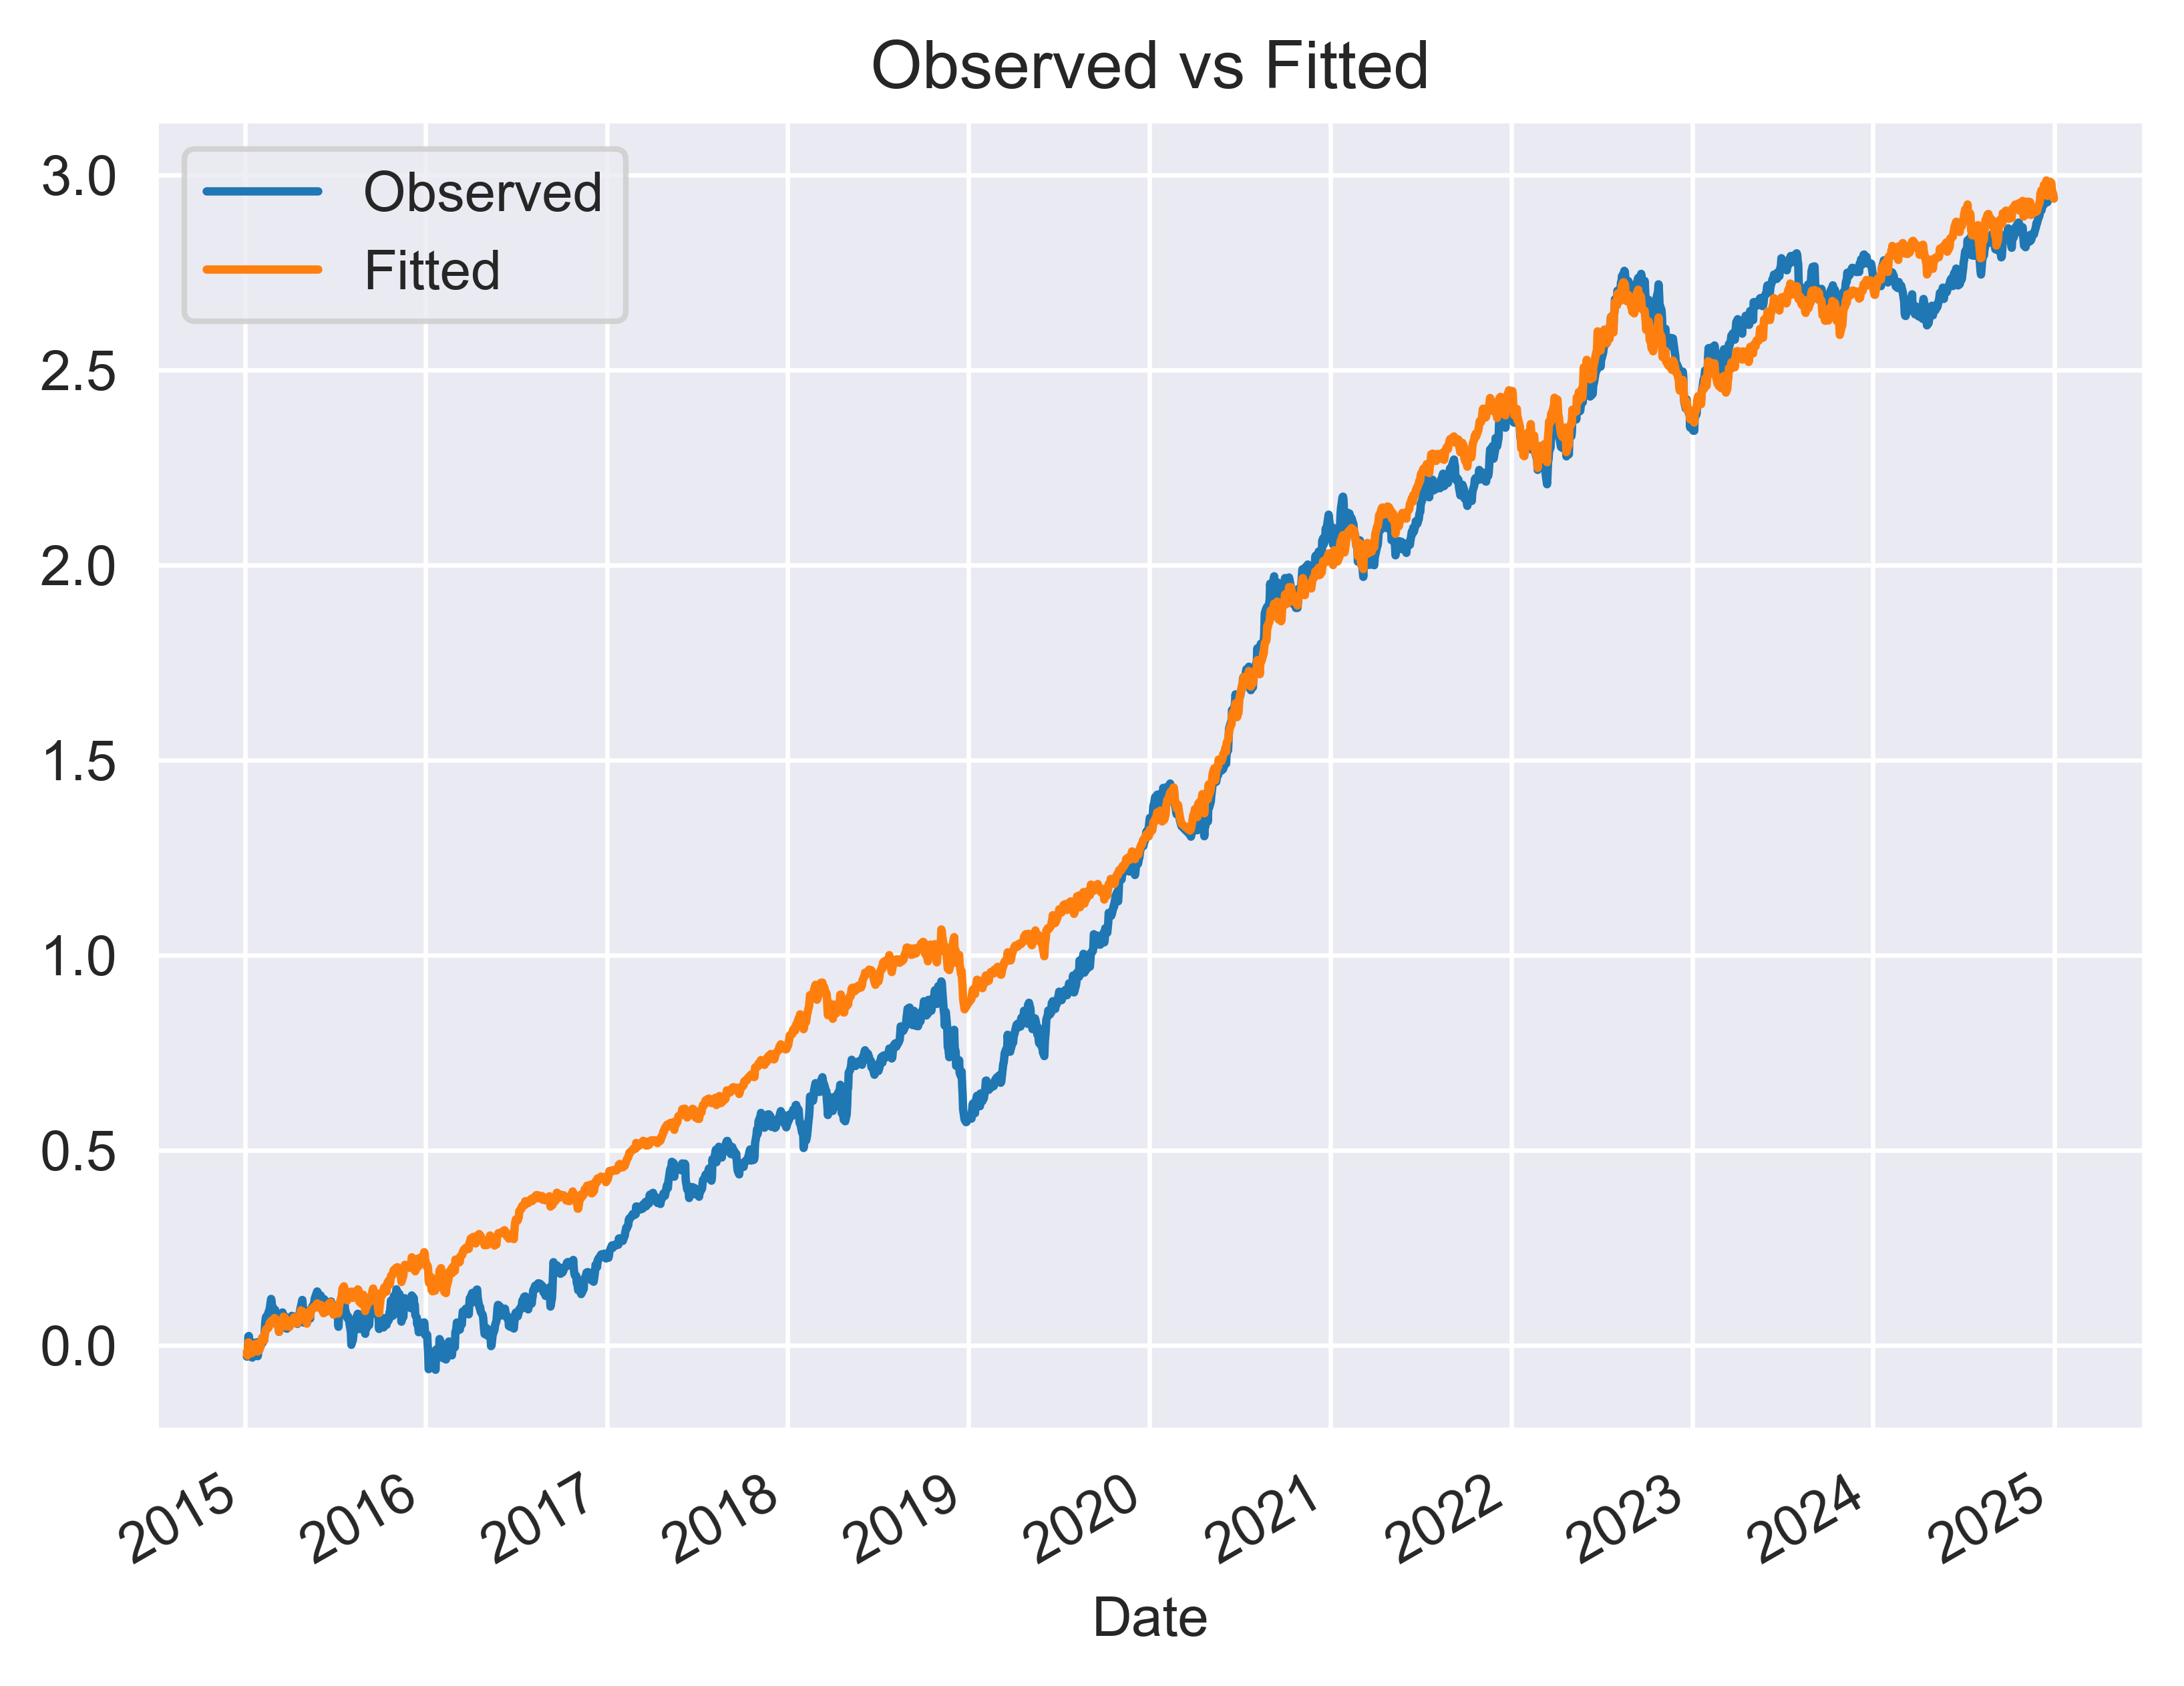

In [39]:
fig, ax1 = plt.subplots(dpi = 600)

filtered_data['expected_returns'] = Y_Hat

filtered_data['returns'].cumsum().plot(label = 'Observed')
filtered_data['expected_returns'].cumsum().plot(label = 'Fitted')
plt.legend()
plt.title('Observed vs Fitted')

plt.show()

In [40]:
# We can obtain the Hat Matrix, which is a matrix used to transform the real values into the fitted values
Some_Matrix = Information_Matrix.dot(X_Variance_Matrix_Inverse)
Hat_Matrix = Some_Matrix.to_numpy() @ Information_Matrix_T.to_numpy()

Hat_Matrix

array([[ 2.94082036e-03,  1.59023072e-03, -3.66144935e-04, ...,
         8.44076251e-04,  1.16591161e-03,  3.32593481e-04],
       [ 1.59023072e-03,  1.04602986e-03,  4.68035200e-05, ...,
         5.18992304e-04,  5.86405229e-04,  2.57076775e-04],
       [-3.66144935e-04,  4.68035200e-05,  1.75739121e-03, ...,
        -9.11200359e-04, -5.90200943e-04,  1.25817428e-04],
       ...,
       [ 8.44076251e-04,  5.18992304e-04, -9.11200359e-04, ...,
         3.10013788e-03,  2.72471311e-03,  2.43939977e-03],
       [ 1.16591161e-03,  5.86405229e-04, -5.90200943e-04, ...,
         2.72471311e-03,  2.63210839e-03,  2.33313511e-03],
       [ 3.32593481e-04,  2.57076775e-04,  1.25817428e-04, ...,
         2.43939977e-03,  2.33313511e-03,  2.68754282e-03]])

In [41]:
print(Information_Matrix.shape)
print(X_Variance_Matrix_Inverse.shape)
print(Some_Matrix.shape)
print(Information_Matrix_T.shape)

(2425, 5)
(5, 5)
(2425, 5)
(5, 2425)


In [42]:
# Let us check if this is true
Y_Hat_2 = Hat_Matrix.dot(Y_Vector)

Y_Hat_2

array([-0.01647117, -0.00941594,  0.01407485, ..., -0.01687952,
       -0.01346491, -0.0096148 ])

In [43]:
# Hat Matrix is Symmetric and Idempotent

Hat_Matrix_Square = (Hat_Matrix.transpose()).dot(Hat_Matrix)

if Hat_Matrix.all() == Hat_Matrix_Square.all():
    print("It is indeed idempotent")
else:
    print("Wrong!")

It is indeed idempotent


In [44]:
# We can calculate the residuals using the Hat Matrix
Identity_Matrix = np.identity(len(Y_Vector))
Residuals_Vector = (Identity_Matrix - Hat_Matrix).dot(Y_Vector)

print(f"The Residuals Mean is: {Residuals_Vector.mean().round(3)}")
print(f"The Residuals Variance is: {Residuals_Vector.var()}")

The Residuals Mean is: -0.0
The Residuals Variance is: 8.901490240828408e-05


In [45]:
# Residual Returns
filtered_data['residuals'] = Residuals_Vector

filtered_data

returns  mkt_returns  sector_returns  dollar_returns  \
Date                                                                
2015-01-05 -0.028576    -0.018447       -0.016820        0.003288   
2015-01-06  0.000094    -0.008933       -0.009333        0.001312   
2015-01-07  0.013925     0.011563        0.012760        0.004253   
2015-01-08  0.037702     0.017730        0.018346        0.005210   
2015-01-09  0.001072    -0.008439       -0.007537       -0.004666   
...              ...          ...             ...             ...   
2024-12-24  0.011413     0.010982        0.013657        0.002034   
2024-12-26  0.003171    -0.000406       -0.001805       -0.001202   
2024-12-27 -0.013331    -0.011117       -0.014681       -0.001203   
2024-12-30 -0.013352    -0.010760       -0.012155        0.001203   
2024-12-31 -0.007083    -0.004294       -0.007917        0.003324   

            10_year_bond  expected_returns  residuals  
Date                                                   
2015-01-05      0.000080         -0.016471  -0.012105  
2015-01-06      0.000077         -0.009416   0.009510  
2015-01-07      0.000077          0.014075  -0.000150  
2015-01-08      0.000079          0.019719   0.017983  
2015-01-09      0.000077         -0.007542   0.008615  
...                  ...               ...        ...  
2024-12-24      0.000178          0.014450  -0.003037  
2024-12-26      0.000178         -0.002920   0.006091  
2024-12-27      0.000179         -0.016880   0.003549  
2024-12-30      0.000176         -0.013465   0.000113  
2024-12-31      0.000177         -0.009615   0.002532  

[2425 rows x 7 columns]

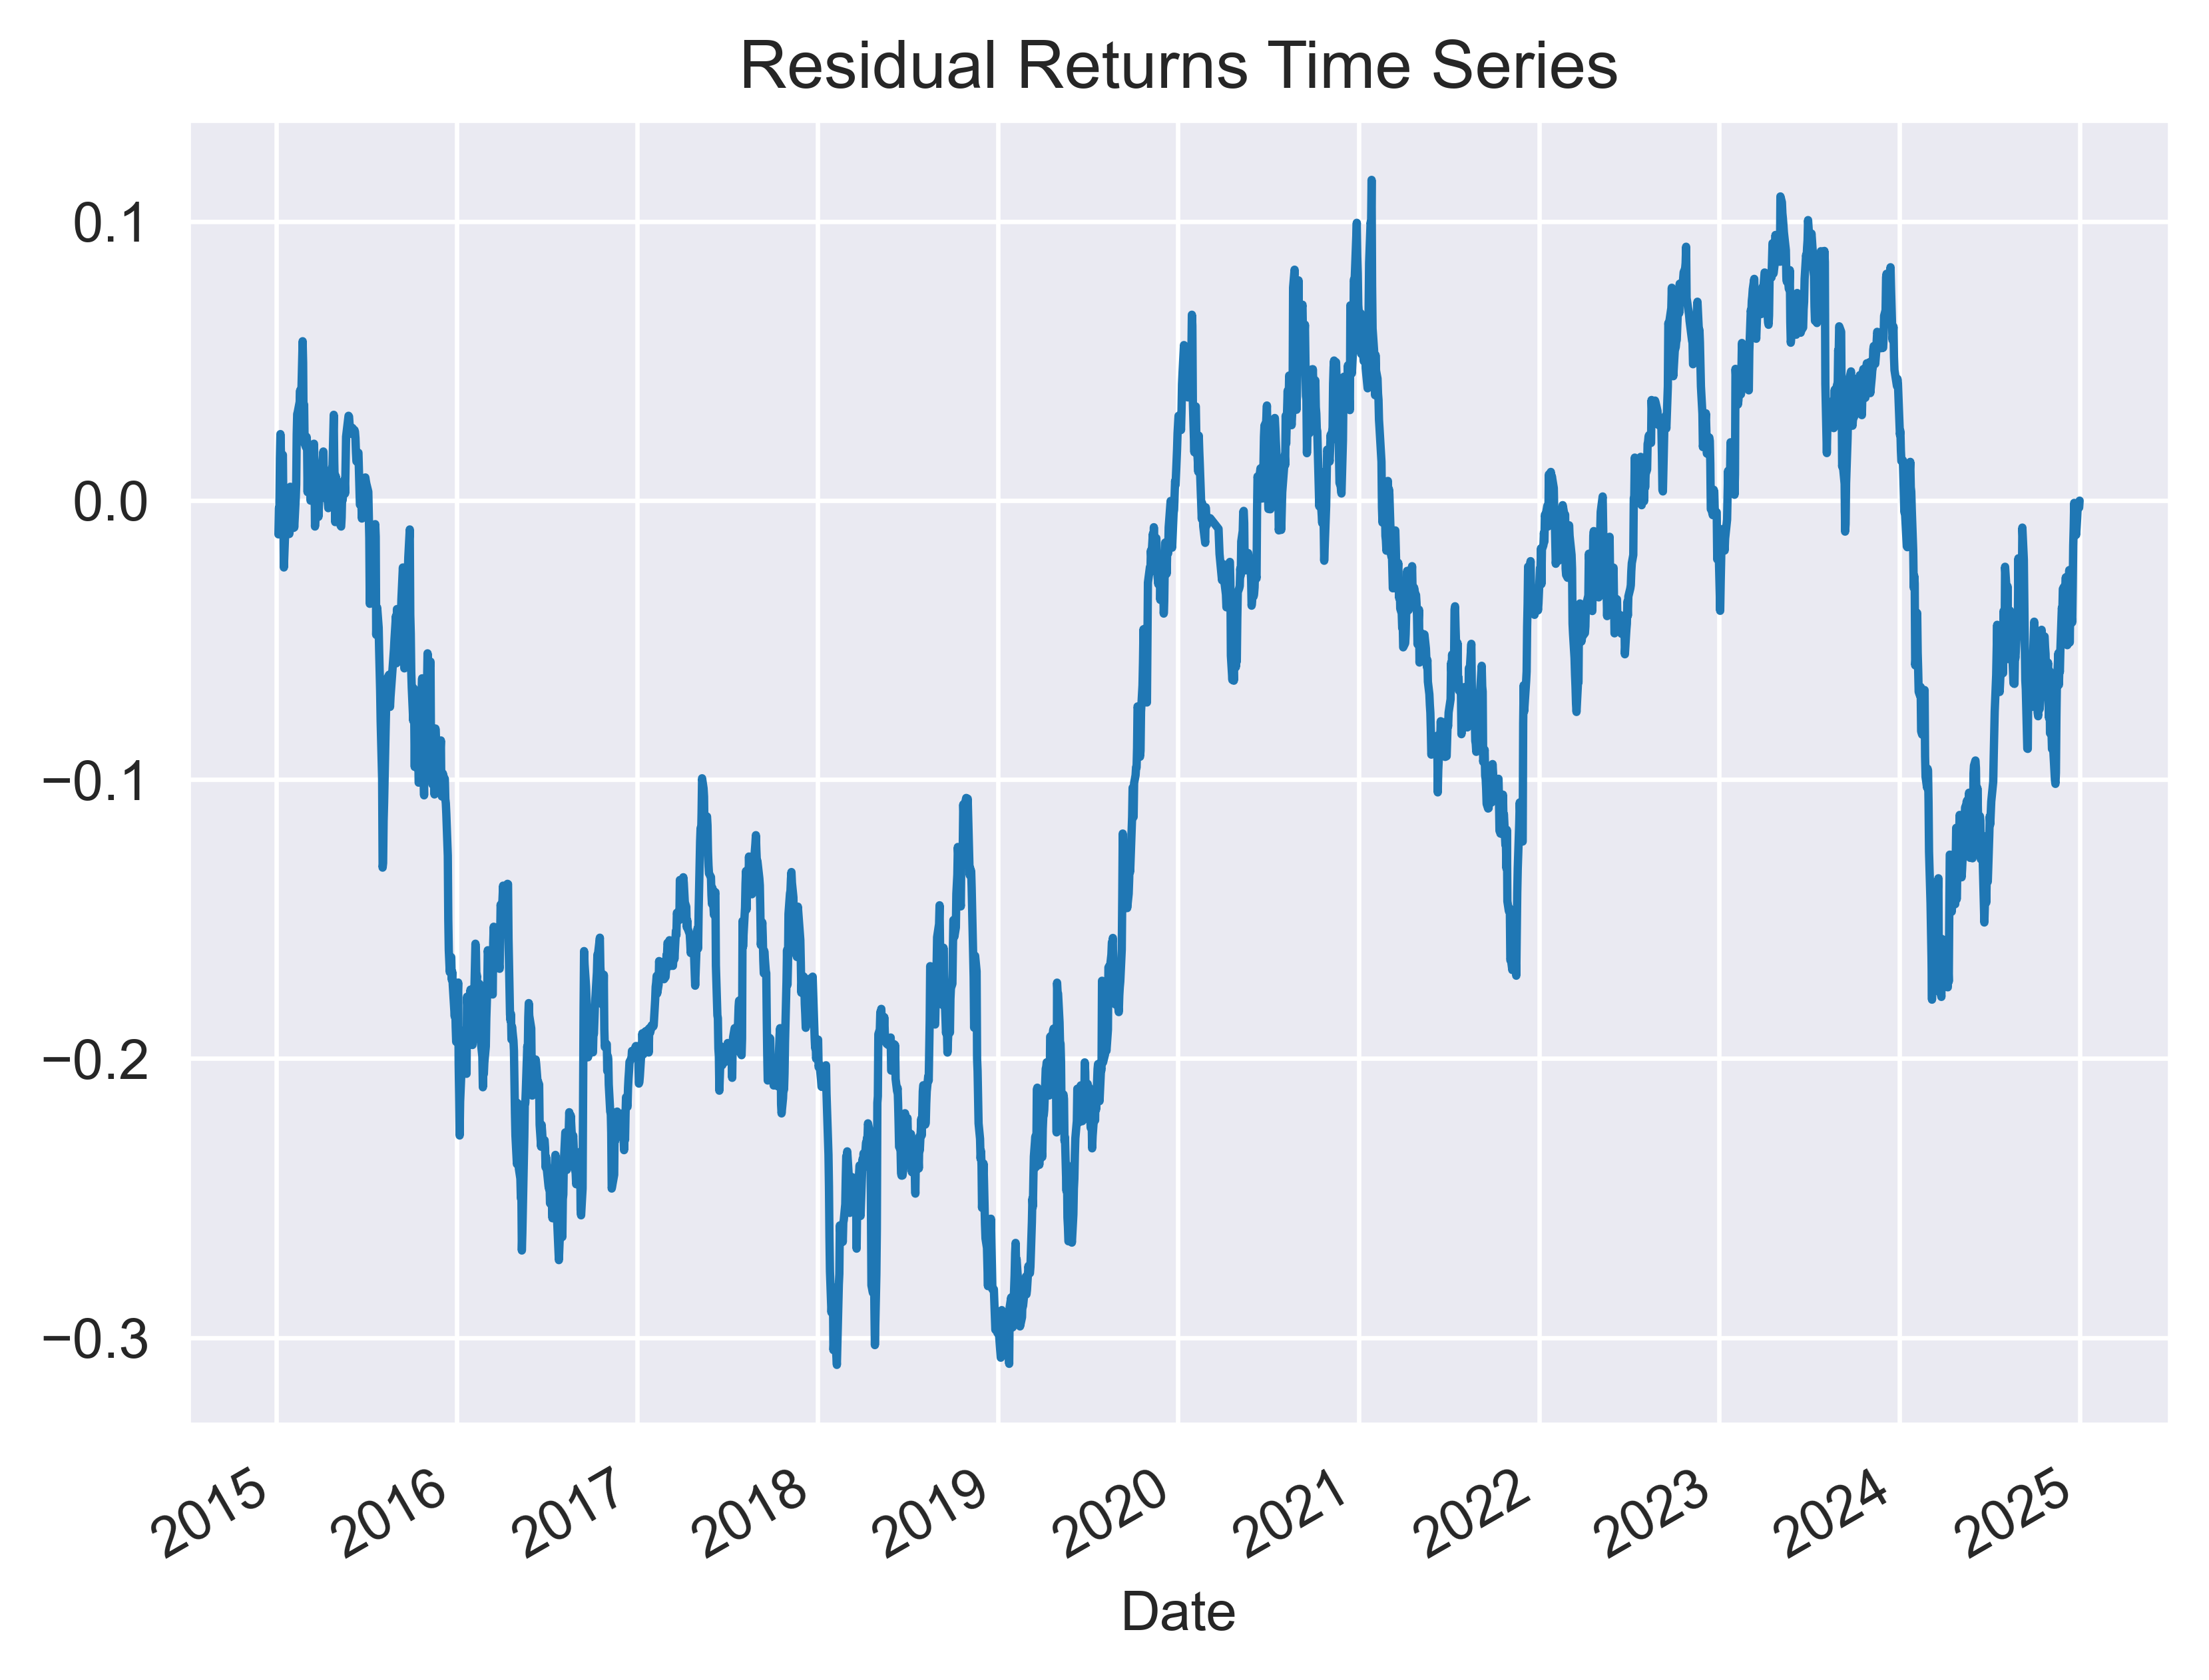

In [46]:
# Plot
fig, ax1 = plt.subplots(dpi = 600)
filtered_data['residuals'].cumsum().plot()
plt.title('Residual Returns Time Series')
plt.show()

In [47]:
# The OLS Assumptions establish that the covariances and the residuals must be uncorrelated
Intercorrelation_Vector = Information_Matrix_T.dot(Residuals_Vector)

print(Intercorrelation_Vector.round(5))

const            -0.0
mkt_returns       0.0
sector_returns   -0.0
dollar_returns   -0.0
10_year_bond     -0.0
dtype: float64


We can use this expression to calculate the Bias of the Beta coefficients:

1) $ S=(\mathbf{X}^⊤\mathbf{X})^{-1}(\mathbf{X}^⊤\boldsymbol{\varepsilon}) $


In [49]:
# Calculate Bias
Bias = X_Variance_Matrix_Inverse.dot(Intercorrelation_Vector)

print("""
Biases are very close to zero.
""")
print(Bias)


Biases are very close to zero.

[ 8.21229759e-19  5.84138685e-15 -4.57622806e-15  2.40529426e-16
 -2.93933342e-14]


Now we want to calculate the sum of squares

1) $ RSS=\boldsymbol{\varepsilon}^⊤\boldsymbol{\varepsilon}=\mathbf{y}^⊤\mathbf{y}-\boldsymbol{\beta}^⊤\mathbf{X}^⊤\mathbf{y} $
2) $ ESS=\boldsymbol{\beta}^⊤\mathbf{X}^⊤\mathbf{y}-\bar{\mathbf{y}}^2 $
3) $ TSS=\mathbf{y}^⊤\mathbf{y}-\bar{\mathbf{y}}^2 $

In [51]:
RSS = (Residuals_Vector.transpose()).dot(Residuals_Vector)
ESS = (Beta.transpose()).dot(Y_Covariance_X) - (sum(Y_Vector)**2)/len(Y_Vector)
TSS = (Y_Vector.transpose()).dot(Y_Vector) - (sum(Y_Vector)**2)/len(Y_Vector)

print(f"The Residuals Sum of Squares is: {RSS}")
print(f"The Estimation Sum of Squares is: {ESS}")
print(f"The Total Sum of Squares is: {TSS}")

The Residuals Sum of Squares is: 0.2158611383400889
The Estimation Sum of Squares is: 0.31847865707979456
The Total Sum of Squares is: 0.5343397954198836


In [52]:
# We can calculate the R-Squared Coefficient
R_Squared = ESS/TSS

print(f"The R-Squared Coefficient is: {R_Squared}")

The R-Squared Coefficient is: 0.5960227177718148


In [53]:
# Now calculate the Residual Variance with n - k degrees of freedom (adjusted to the sample)
Residuals_Variance = RSS/(len(Y_Vector) - Hat_Matrix.trace())

print(f"The Residuals Variance is: {Residuals_Variance}")

The Residuals Variance is: 8.91988174959045e-05


We use the Residual Variance to calculate the covariances between all the beta coefficients:

1) $ C=\frac{\boldsymbol{\varepsilon}^⊤\boldsymbol{\varepsilon}}{n-k}(\mathbf{X}^⊤\mathbf{X})^{-1} $

In [55]:
# The Diagonal of the Covariance Matrix contains the standard errors of the beta coefficients
Covariance_Matrix = (Residuals_Variance)*X_Variance_Matrix_Inverse

Covariance_Matrix

array([[ 2.49448377e-07, -3.62801166e-07, -2.21606600e-07,
         4.60734546e-07, -2.17969337e-03],
       [-3.62801166e-07,  3.73434993e-03, -2.92547636e-03,
         2.20533806e-04,  5.76304734e-03],
       [-2.21606600e-07, -2.92547636e-03,  2.63423489e-03,
        -7.78366036e-05, -2.87612041e-03],
       [ 4.60734546e-07,  2.20533806e-04, -7.78366036e-05,
         2.33059024e-03, -7.17836713e-03],
       [-2.17969337e-03,  5.76304734e-03, -2.87612041e-03,
        -7.17836713e-03,  2.23796039e+01]])

In [56]:
# Take the squared-root
Beta_Standards_Errors = np.sqrt(Covariance_Matrix.diagonal())

Beta_Standards_Errors

array([4.99448072e-04, 6.11093277e-02, 5.13247980e-02, 4.82761871e-02,
       4.73070861e+00])

In [57]:
# Calculate the T-Values
T_Values = Beta/Beta_Standards_Errors

T_Values

array([ 1.84089816, -4.78292969, 25.84116896,  1.25092439, -1.77472304])

In [58]:
# How many degrees of freedom we have?
df = len(Y_Vector) - Hat_Matrix.trace()

print(f"We have {df.round()} degrees of freedom.")

We have 2420.0 degrees of freedom.


In [59]:
# The Hypothesis Testing implies to reject the null hypothesis if the t-values are higher than the critic t-value
# For 293 degrees of freedom the critic t-value approaches to 1.96
# Then we can calculate the upper and lower limits

Beta_Lower_Limit = Beta - 1.96*Beta_Standards_Errors
Beta_Upper_Limit = Beta + 1.96*Beta_Standards_Errors

print(Beta_Lower_Limit)
print(Beta_Upper_Limit)

[-5.94851846e-05 -4.12055900e-01  1.22569617e+00 -3.42314669e-02
 -1.76678864e+01]
[ 0.00189835 -0.17250734  1.42688938  0.15501119  0.8764913 ]


In [61]:
# We can build a dataframe that contains all the information
Proof_DF = pd.DataFrame(
    {
     "T_Values": T_Values, 
     "Beta_Inferior_Limit": Beta_Lower_Limit, 
     "Beta_Superior_Limit": Beta_Upper_Limit
     }
    )

Proof_DF

T_Values  Beta_Inferior_Limit  Beta_Superior_Limit
0   1.840898            -0.000059             0.001898
1  -4.782930            -0.412056            -0.172507
2  25.841169             1.225696             1.426889
3   1.250924            -0.034231             0.155011
4  -1.774723           -17.667886             0.876491

In [62]:
# Let us get the p-values, if these are less than 0.05, we reject the null hypothesis confirming statistically significance
Proof_DF["p-values"] = 2*(t.sf(
    abs(Proof_DF.T_Values), 
    len(Y_Vector) - Hat_Matrix.trace()
    ).round(3)
    )

Proof_DF

T_Values  Beta_Inferior_Limit  Beta_Superior_Limit  p-values
0   1.840898            -0.000059             0.001898     0.066
1  -4.782930            -0.412056            -0.172507     0.000
2  25.841169             1.225696             1.426889     0.000
3   1.250924            -0.034231             0.155011     0.212
4  -1.774723           -17.667886             0.876491     0.076

In [63]:
"""
The R-Squared is not always the most precise staitstic in a multilinear model
The Adjusted R-Squared penalizes the existence of more variables in our model:
    
    Adjusted R Squared = 1 – [((1 – R2) * (n – 1)) / (n – k)]
    
"""
R_Squared_Adjusted = (1 - ((1-R_Squared)*(len(Y_Vector) - 1)/(len(Y_Vector) - Hat_Matrix.trace())))

print(f"The Adjusted R-Squared is: {R_Squared_Adjusted.round(5)}")

The Adjusted R-Squared is: 0.59535


The F-Statistic helps us to prove Joint Significance.
This means that we are checking if our models as a whole can explain the Y

The F statistic is distributed in an F-distribution with n - k and
k - 1 degrees of freedom.


1) $ F=\frac{ESS/k-1}{RSS/n-k} $


In [65]:
# Calculate the F Stat
F_Stat = (ESS/(Hat_Matrix.trace() - 1)) / (RSS/(len(Y_Vector) - Hat_Matrix.trace()))

print(f"The F-Statistic is: {F_Stat}")

The F-Statistic is: 892.608966185053


In [66]:
#Model specification
model = sm.OLS(
    Y_Vector, 
    sm.add_constant(Information_Matrix)
    )   
     
#the results of the model
results = model.fit() 
    
#The Parameters
Beta2 = results.params  

#here we check the summary
print(results.summary())       

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     892.6
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        11:38:19   Log-Likelihood:                 7867.7
No. Observations:                2425   AIC:                        -1.573e+04
Df Residuals:                    2420   BIC:                        -1.570e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0009      0.000      1.

In [67]:
Beta

array([ 9.19433037e-04, -2.92281617e-01,  1.32629278e+00,  6.03898599e-02,
       -8.39569757e+00])

In [68]:
# Calculate the VIF
X = Information_Matrix

vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

vars       VIF
0           const  6.781618
1     mkt_returns  7.823732
2  sector_returns  7.785089
3  dollar_returns  1.018433
4    10_year_bond  1.001991

In [69]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = X.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

vars  r_squared
0           const   0.852543
1     mkt_returns   0.872184
2  sector_returns   0.871549
3  dollar_returns   0.018100
4    10_year_bond   0.001987

In [70]:
#Model specification
model = sm.OLS(
    Y_Vector, 
    sm.add_constant(X.drop(['mkt_returns'], axis=1))
    )   
     
#the results of the model
results = model.fit() 

#here we check the summary
print(results.summary())   

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1172.
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        11:39:33   Log-Likelihood:                 7856.3
No. Observations:                2425   AIC:                        -1.570e+04
Df Residuals:                    2421   BIC:                        -1.568e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0009      0.001      1.

In [71]:
# Calculate the VIF

X = Information_Matrix.drop(['mkt_returns'], axis=1)

vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

vars       VIF
0           const  6.780660
1  sector_returns  1.011993
2  dollar_returns  1.012742
3    10_year_bond  1.001593